In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

sys.path.insert(0, "..")
from src import data, config, visualization, preprocessing, utils, models

from src.figure import PredictionFigure

import kaleido
import plotly.io as pio

/home/nchagnet/devs/tutorials/energy-demand-forecast/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from importlib import reload  # Not needed in Python 2
import logging

reload(logging)

<module 'logging' from '/home/nchagnet/.local/share/uv/python/cpython-3.11.9-linux-x86_64-gnu/lib/python3.11/logging/__init__.py'>

## Model comparison

We are going to use a whole day as testing data

In [4]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

interpolator = preprocessing.LinearlyInterpolateTS()
y_actual = interpolator.apply(data.load_timeseries())
y_forecast = interpolator.apply(data.load_timeseries_forecast())
n_days = 3
end_dev = y_actual.index.max() - pd.Timedelta(days=n_days)

reference_mape = mean_absolute_percentage_error(y_actual, y_forecast)
reference_mae = mean_absolute_error(y_actual, y_forecast)
print(f"Reference MAPE over {n_days} days: {reference_mape}, MAE: {reference_mae}")

Reference MAPE over 3 days: 0.019728608087665307, MAE: 993.4942341325607


Let's start by comparing LGBM with XGBoost using adaptive train size.

In [5]:
model_lgbm = models.ForecasterRecursiveLGBM(iteration=0, end_dev=end_dev, save_model_to_file=False)
model_xgb = models.ForecasterRecursiveXGB(iteration=0, end_dev=end_dev, save_model_to_file=False)

We tune them both using the dev set.

In [7]:
model_lgbm.tune()
error_model_lgbm = model_lgbm.backtest()

[I 2025-01-04 16:49:31,295] A new study created in memory with name: no-name-4afadaa6-ae13-40fc-bcf2-e1d4a7c5245d
100%|██████████| 73/73 [00:08<00:00,  8.76it/s]


In [8]:
prediction_lgbm = model_lgbm.package_prediction()

In [9]:
fig_lgbm = PredictionFigure(prediction_lgbm)
fig_lgbm.make_plot()

In [10]:
pio.orca.config.executable = "orca"
pio.orca.config.save()

fig_lgbm.save_to_file("/home/nchagnet/lgbm_all_data.png", width=1280, scale=2, engine="orca")

/home/nchagnet/devs/tutorials/energy-demand-forecast/.venv/lib/python3.11/site-packages/plotly/io/_orca.py:1445: ResourceWarning:

unclosed file <_io.BufferedWriter name='/dev/null'>



In [7]:
model_xgb.tune()
error_model_xgb = model_xgb.backtest()

[I 2025-01-03 21:39:53,276] A new study created in memory with name: no-name-fdf4eeca-38ba-4b88-ab1d-a5061feb7110
100%|██████████| 1/1 [00:00<00:00, 282.84it/s]


In [ ]:
display(error_model_lgbm)
display(error_model_xgb)

,mean_absolute_error,mean_absolute_percentage_error
0,1927.189795,0.032051


,mean_absolute_error,mean_absolute_percentage_error
0,2618.426084,0.043018


Now the same thing but with a fixed train size

In [11]:
model_lgbm_fixed = models.ForecasterRecursiveLGBM(
    iteration=0, end_dev=end_dev, train_size=pd.Timedelta(days=365 * 3), save_model_to_file=False
)
model_xgb_fixed = models.ForecasterRecursiveXGB(
    iteration=0, end_dev=end_dev, train_size=pd.Timedelta(days=365 * 3), save_model_to_file=False
)

In [12]:
model_lgbm_fixed.tune()
error_model_lgbm_fixed = model_lgbm_fixed.backtest()

[I 2025-01-04 17:05:46,247] A new study created in memory with name: no-name-18f0d2be-a7a3-4f56-b647-c2b8d7bc8aa4
100%|██████████| 1170/1170 [00:51<00:00, 22.56it/s]


In [13]:
model_lgbm_fixed.fit_with_best()

In [14]:
prediction_lgbm_fixed = model_lgbm_fixed.package_prediction()
fig_lgbm_fixed = PredictionFigure(prediction_lgbm_fixed)
fig_lgbm_fixed.make_plot()


In [20]:
fig_lgbm_fixed.save_to_file("/home/nchagnet/lgbm_fixed_data.png", width=1280, scale=2, engine="orca")

In [13]:
model_xgb_fixed.tune()
error_model_xgb_fixed = model_xgb_fixed.backtest()

[I 2025-01-03 22:03:57,630] A new study created in memory with name: no-name-f8281e36-3594-4c37-85ae-e23d22b45e97
100%|██████████| 1100/1100 [01:31<00:00, 12.00it/s]


In [14]:
display(error_model_lgbm_fixed)
display(error_model_xgb_fixed)

,mean_absolute_error,mean_absolute_percentage_error
0,1578.493391,0.032218


,mean_absolute_error,mean_absolute_percentage_error
0,1592.260611,0.031815


In [21]:
model_lgbm_fixed.get_feature_importance().head(10)

,feature,importance
0,lag_1,2856
21,daily_0,1807
23,daily_2,1806
24,daily_3,1384
56,yearly_0,1141
1,lag_2,1110
25,daily_4,1100
26,daily_5,1087
22,daily_1,953
2,lag_3,740


In [22]:
import shap

In [23]:
model_lgbm_fixed.fit_with_best()

In [24]:
X_train, y_train = model_lgbm_fixed._get_training_data()
X_train_sample = X_train.sample(frac=0.1)

shap.initjs()

In [25]:
explainer = shap.TreeExplainer(model_lgbm_fixed.forecaster.regressor)
shap_values = explainer.shap_values(X_train_sample)

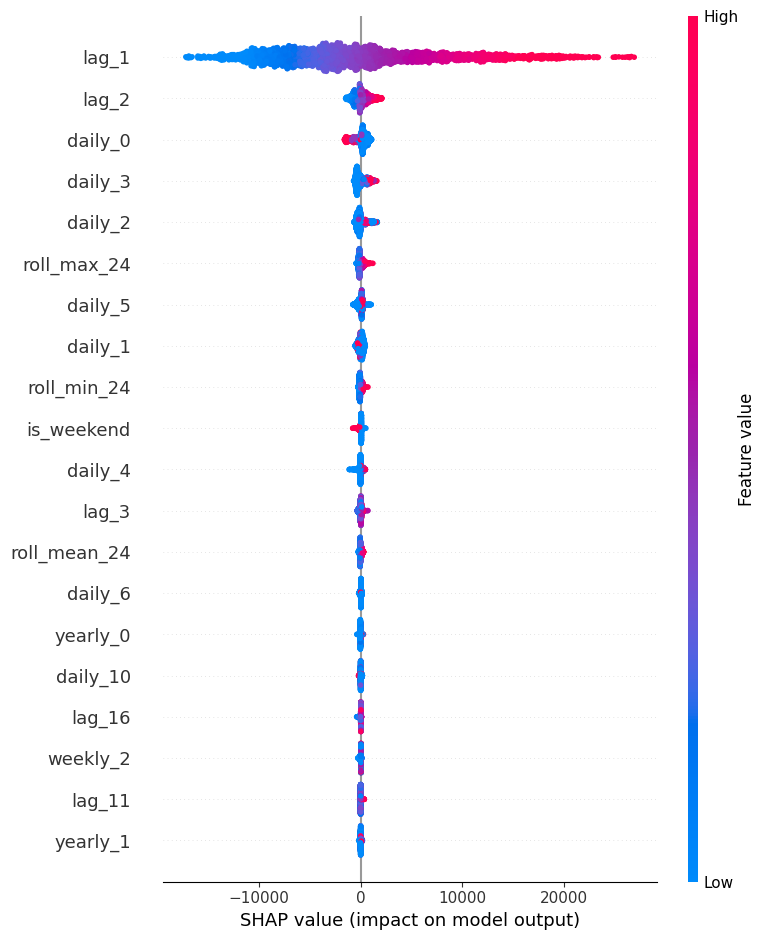

In [26]:
shap.summary_plot(shap_values, X_train_sample, show=False)
plt.savefig("/home/nchagnet/shap_plot.png", dpi=300, bbox_inches="tight")
plt.show()